<a href="https://colab.research.google.com/github/Taha0229/hand-sign-detection-ResNet50/blob/main/hand_sign_digit_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**ResNet**
In this notebook I am leveraging ResNet to build a highly performant sign language digit detection model.


In [33]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from resnets_utils import *
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from matplotlib.pyplot import imshow


%matplotlib inline
np.random.seed(1)
tf.random.set_seed(2)

#**Identity and Conv Blocks Architecture**
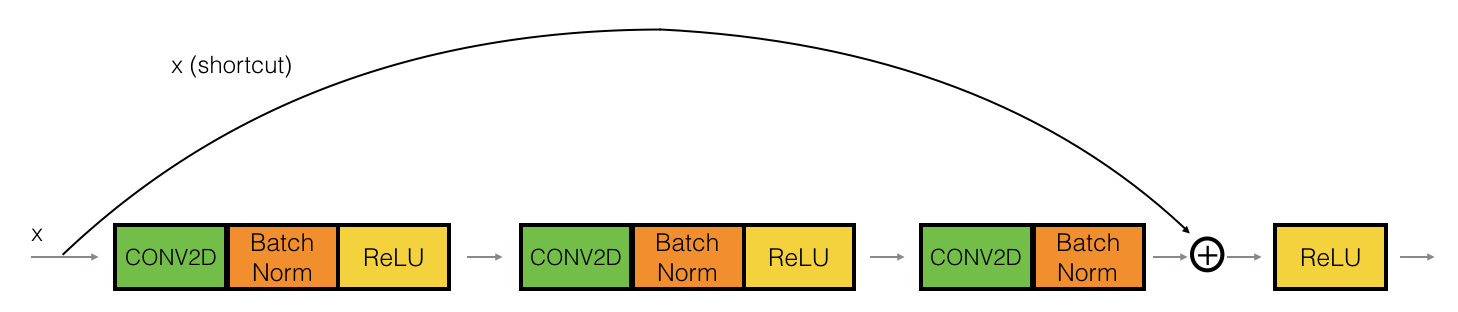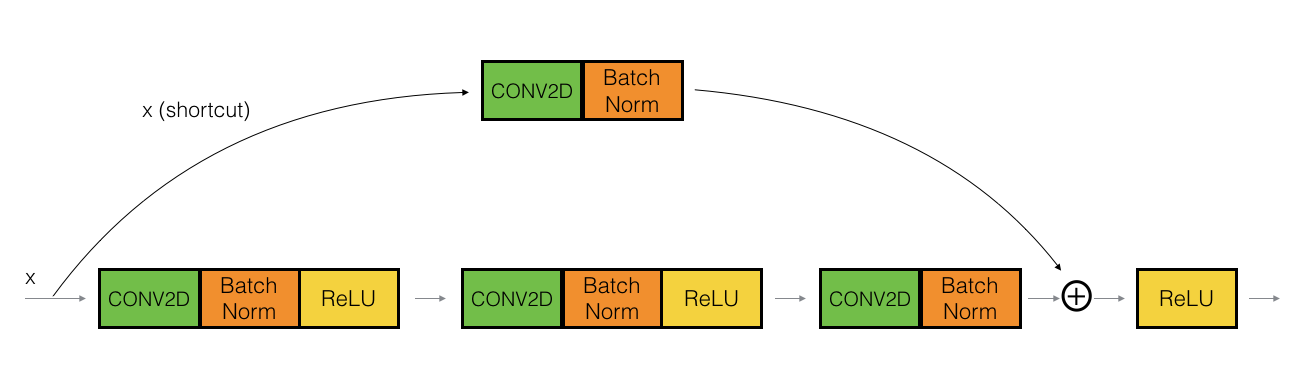

#**Targetted ResNet Architure:**
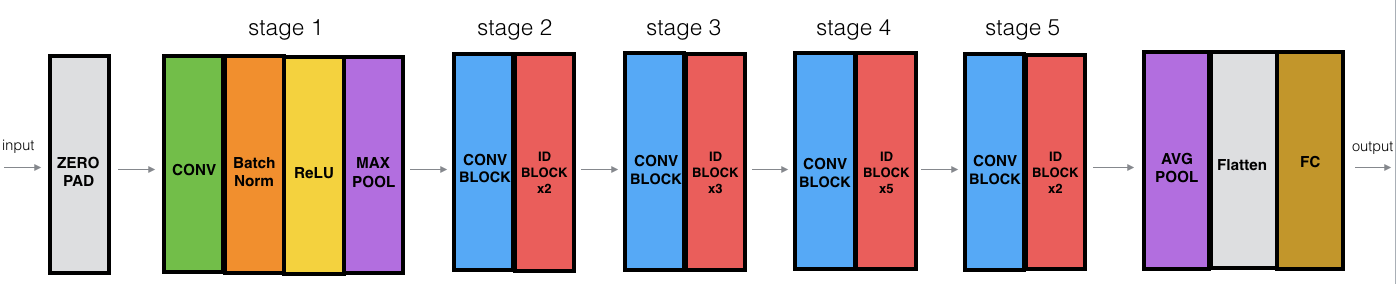

In [17]:
def identity_block(X, f, filters, initializer=random_uniform):
    """
    Implementation of the identity block

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer

    Returns:
    X -- output of the identity block, tensor of shape (m, n_H, n_W, n_C)
    """

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value.
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X) # Default axis
    X = Activation('relu')(X)


    ## Second component of main path
    X = Conv2D(filters = F2, kernel_size = f, strides = (1,1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    ## Third component of main path
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)

    ## Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [18]:
def convolutional_block(X, f, filters, s = 2, initializer=glorot_uniform):
    """
    Implementation of the convolutional block

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer,
                   also called Xavier uniform initializer.

    Returns:
    X -- output of the convolutional block, tensor of shape (m, n_H, n_W, n_C)
    """

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####

    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)


    ## Second component of main path
    X = Conv2D(filters = F2, kernel_size = f, strides = (1, 1), padding='same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    ## Third component of main path
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1, 1), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)

    ##### SHORTCUT PATH #####
    X_shortcut = Conv2D(filters = F3, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut)

    ### END CODE HERE

    # Final step: Add shortcut value to main path and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X


In [19]:
def ResNet50(input_shape = (64, 64, 3), classes = 6, training=False):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)


    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    ## Stage 3
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2)

    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])

    # Stage 4
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    # AVGPOOL
    X = AveragePooling2D(pool_size=(2, 2))(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)


    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [20]:
tf.keras.backend.set_learning_phase(True)

model = ResNet50(input_shape = (64, 64, 3), classes = 6)
print(model.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 zero_padding2d_1 (ZeroPadd  (None, 70, 70, 3)            0         ['input_2[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv2d_53 (Conv2D)          (None, 32, 32, 64)           9472      ['zero_padding2d_1[0][0]']    
                                                                                                  
 batch_normalization_53 (Ba  (None, 32, 32, 64)           256       ['conv2d_53[0][0]']     

**Note:** <br>
**(1)** In the context of a machine learning model, when the learning phase is set to `True`, layers like dropout layers may operate in `training mode`, where `dropout` is applied to the inputs. When the learning phase is set to `False`, these layers may operate in inference mode, where dropout is turned off, and the model is used for making predictions.
<br>
**(2)** It's worth noting that starting from TensorFlow 2.0 and Keras integrated within TensorFlow, you may not need to use tf.keras.backend.set_learning_phase explicitly in many cases. The learning phase is often managed automatically during training and testing, and dropout layers, for example, are applied accordingly.

If you are using TensorFlow 2.x with eager execution, the learning phase is usually handled automatically, and you might not need to explicitly set it. Always refer to the documentation and specific use cases for the version of TensorFlow you are working with.

#**Compile the model**

In [21]:
np.random.seed(1)
tf.random.set_seed(2)
opt = tf.keras.optimizers.Adam(learning_rate=0.00015)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

#**Load datasets**

In [22]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig / 255.
X_test = X_test_orig / 255.

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


#**Fit the model**

In [37]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(64)
history = model.fit(train_dataset, epochs=50, validation_data=test_dataset)

Epoch 1/50
17/17 [==============================] - 22s 427ms/step - loss: 2.2706e-04 - accuracy: 1.0000 - val_loss: 0.1889 - val_accuracy: 0.9667
Epoch 2/50
17/17 [==============================] - 3s 202ms/step - loss: 1.1471e-04 - accuracy: 1.0000 - val_loss: 0.1904 - val_accuracy: 0.9667
Epoch 3/50
17/17 [==============================] - 2s 145ms/step - loss: 9.5262e-05 - accuracy: 1.0000 - val_loss: 0.1909 - val_accuracy: 0.9667
Epoch 4/50
17/17 [==============================] - 2s 146ms/step - loss: 8.4689e-05 - accuracy: 1.0000 - val_loss: 0.1910 - val_accuracy: 0.9667
Epoch 5/50
17/17 [==============================] - 2s 146ms/step - loss: 7.7480e-05 - accuracy: 1.0000 - val_loss: 0.1911 - val_accuracy: 0.9667
Epoch 6/50
17/17 [==============================] - 2s 145ms/step - loss: 7.1980e-05 - accuracy: 1.0000 - val_loss: 0.1910 - val_accuracy: 0.9667
Epoch 7/50
17/17 [==============================] - 3s 158ms/step - loss: 6.7519e-05 - accuracy: 1.0000 - val_loss: 0.1910 

In [38]:
history.history

{'loss': [0.00022706012532580644,
  0.00011470881145214662,
  9.526153007755056e-05,
  8.468852320220321e-05,
  7.748043572064489e-05,
  7.197999366326258e-05,
  6.751862383680418e-05,
  6.377749377861619e-05,
  6.054992991266772e-05,
  5.7725552323972806e-05,
  5.5218159104697406e-05,
  5.2965089707868174e-05,
  5.092328865430318e-05,
  4.9066657084040344e-05,
  4.736136179417372e-05,
  4.578822336043231e-05,
  4.4335585698718205e-05,
  4.298405474401079e-05,
  4.172006083535962e-05,
  4.053886732435785e-05,
  3.942305556847714e-05,
  3.8372978451661766e-05,
  3.738099985639565e-05,
  3.644328535301611e-05,
  3.555585499270819e-05,
  3.4708125895122066e-05,
  3.39041835104581e-05,
  3.3135533158201724e-05,
  3.239997022319585e-05,
  3.16983787342906e-05,
  3.102767004747875e-05,
  3.038144677702803e-05,
  2.976136420329567e-05,
  2.9169192202971317e-05,
  2.8596874471986666e-05,
  2.8046288207406178e-05,
  2.7516212867340073e-05,
  2.7001806301996112e-05,
  2.6507586881052703e-05,
  2

        loss  accuracy  val_loss  val_accuracy
0   0.000227       1.0  0.188903      0.966667
1   0.000115       1.0  0.190357      0.966667
2   0.000095       1.0  0.190857      0.966667
3   0.000085       1.0  0.191023      0.966667
4   0.000077       1.0  0.191060      0.966667
5   0.000072       1.0  0.191030      0.966667
6   0.000068       1.0  0.190980      0.966667
7   0.000064       1.0  0.190940      0.966667
8   0.000061       1.0  0.190909      0.966667
9   0.000058       1.0  0.190894      0.966667
10  0.000055       1.0  0.190884      0.966667
11  0.000053       1.0  0.190881      0.966667
12  0.000051       1.0  0.190880      0.966667
13  0.000049       1.0  0.190879      0.966667
14  0.000047       1.0  0.190880      0.966667
15  0.000046       1.0  0.190882      0.966667
16  0.000044       1.0  0.190887      0.966667
17  0.000043       1.0  0.190891      0.966667
18  0.000042       1.0  0.190899      0.966667
19  0.000041       1.0  0.190914      0.966667
20  0.000039 

<ipython-input-39-a220caed32a6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
<ipython-input-39-a220caed32a6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

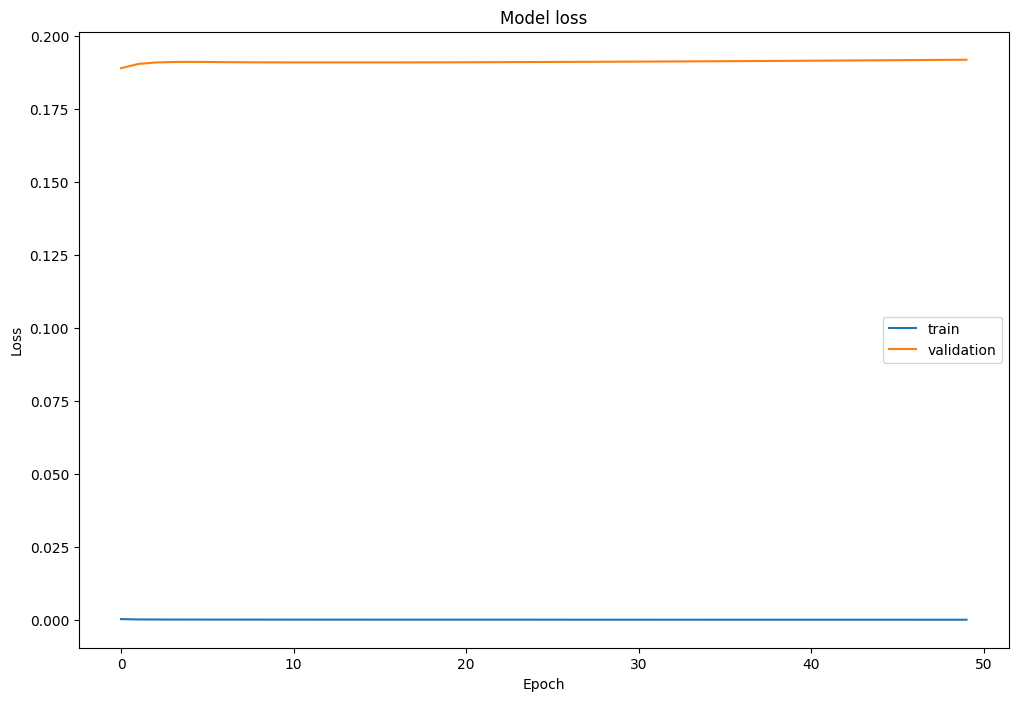

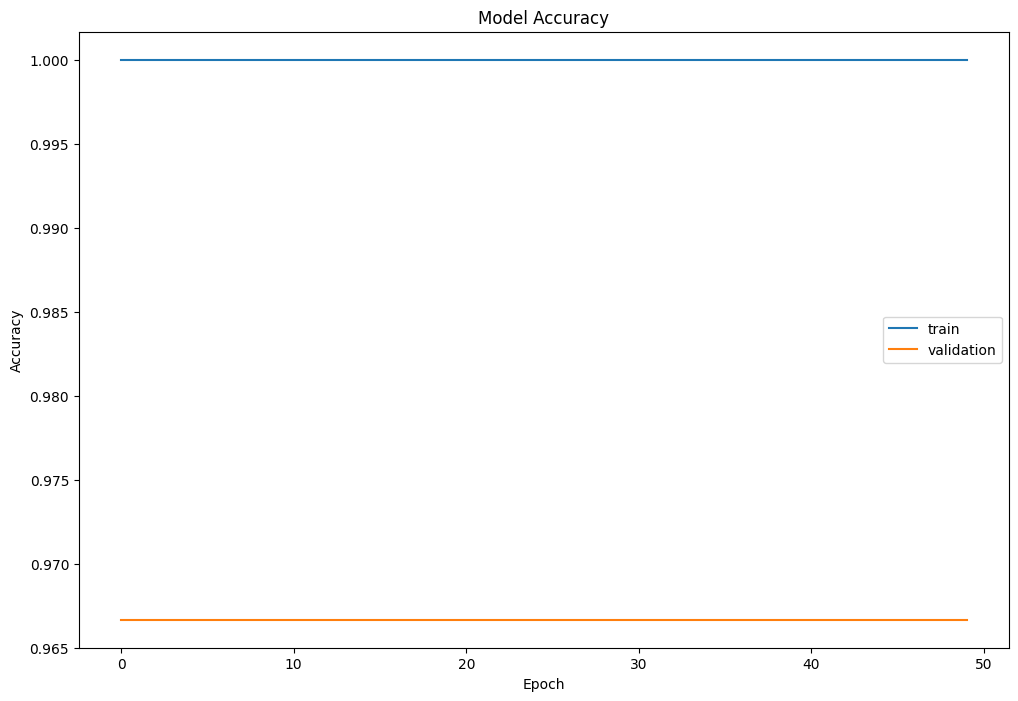

In [39]:
df_loss_acc = pd.DataFrame(history.history)
print(df_loss_acc)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')

#**Evaluate the model**

In [40]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

4/4 [==============================] - 1s 32ms/step - loss: 0.1918 - accuracy: 0.9667
Loss = 0.19180506467819214
Test Accuracy = 0.9666666388511658


#**Testing on my Image**

Input image shape: (1, 64, 64, 3)
1/1 [==============================] - 0s 40ms/step
Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] =  [[5.1824838e-08 9.9409511e-04 9.9725717e-01 1.6445571e-07 1.7486056e-03
  2.8987545e-08]]
Class: 2


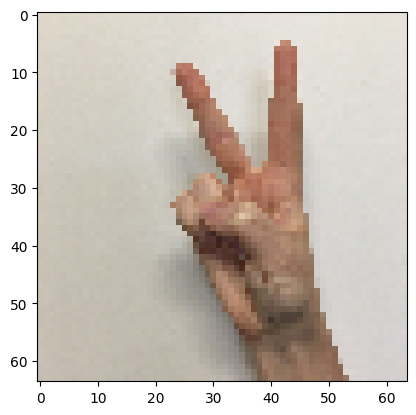

In [44]:
img_path = 'my_image.jpg'
img = image.load_img(img_path, target_size=(64, 64))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0) #adding additional dimension as per the input layer's requirements
x = x/255.0
x2 = x
print('Input image shape:', x.shape)
imshow(img)
prediction = model.predict(x2)
print("Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ", prediction)
print("Class:", np.argmax(prediction))